In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


import tempmatch as tm
import obspy

import helpers

In [2]:
day138 = helpers.import_raw_data_for_single_day('138', '2019', 'b')


In [3]:
day138.decimate(factor=10)
day138_original = day138.copy()


In [4]:
# https://docs.obspy.org/packages/autogen/obspy.signal.filter.bandpass.html#obspy.signal.filter.bandpass
day138.filter(freqmin=5, freqmax=10, corners=4, type='bandpass')

6 Trace(s) in Stream:
7F.B00.01.GDH | 2019-05-18T00:00:02.907000Z - 2019-05-19T00:00:01.017000Z | 100.0 Hz, 8639812 samples
7F.B00.02.GDH | 2019-05-18T00:00:01.540000Z - 2019-05-19T00:00:00.840000Z | 100.0 Hz, 8639931 samples
7F.B00.03.GDH | 2019-05-18T00:00:02.689000Z - 2019-05-19T00:00:03.129000Z | 100.0 Hz, 8640045 samples
7F.B00.04.GDH | 2019-05-18T00:00:02.341000Z - 2019-05-19T00:00:01.081000Z | 100.0 Hz, 8639875 samples
7F.B00.05.GDH | 2019-05-18T00:00:02.971000Z - 2019-05-19T00:00:01.291000Z | 100.0 Hz, 8639833 samples
7F.B00.06.GDH | 2019-05-18T00:00:02.192000Z - 2019-05-19T00:00:01.372000Z | 100.0 Hz, 8639919 samples

In [5]:
day138.detrend('demean')

6 Trace(s) in Stream:
7F.B00.01.GDH | 2019-05-18T00:00:02.907000Z - 2019-05-19T00:00:01.017000Z | 100.0 Hz, 8639812 samples
7F.B00.02.GDH | 2019-05-18T00:00:01.540000Z - 2019-05-19T00:00:00.840000Z | 100.0 Hz, 8639931 samples
7F.B00.03.GDH | 2019-05-18T00:00:02.689000Z - 2019-05-19T00:00:03.129000Z | 100.0 Hz, 8640045 samples
7F.B00.04.GDH | 2019-05-18T00:00:02.341000Z - 2019-05-19T00:00:01.081000Z | 100.0 Hz, 8639875 samples
7F.B00.05.GDH | 2019-05-18T00:00:02.971000Z - 2019-05-19T00:00:01.291000Z | 100.0 Hz, 8639833 samples
7F.B00.06.GDH | 2019-05-18T00:00:02.192000Z - 2019-05-19T00:00:01.372000Z | 100.0 Hz, 8639919 samples

In [6]:
def square_data_in_stream(stream):
    for s in stream:
        s.data = s.data**2
    print('data has been squared')

square_data_in_stream(day138)

data has been squared


In [8]:
day138_original.max()

[94106.193090731191,
 78071.848625352693,
 99722.419170189678,
 106111.83940230079,
 90385.11897945276,
 75998.098937292234]

In [9]:
day138.max()

[758482937.1023041,
 561688740.80828822,
 708674864.22719336,
 1047370075.0101168,
 1396325626.7818725,
 1370758926.4263473]

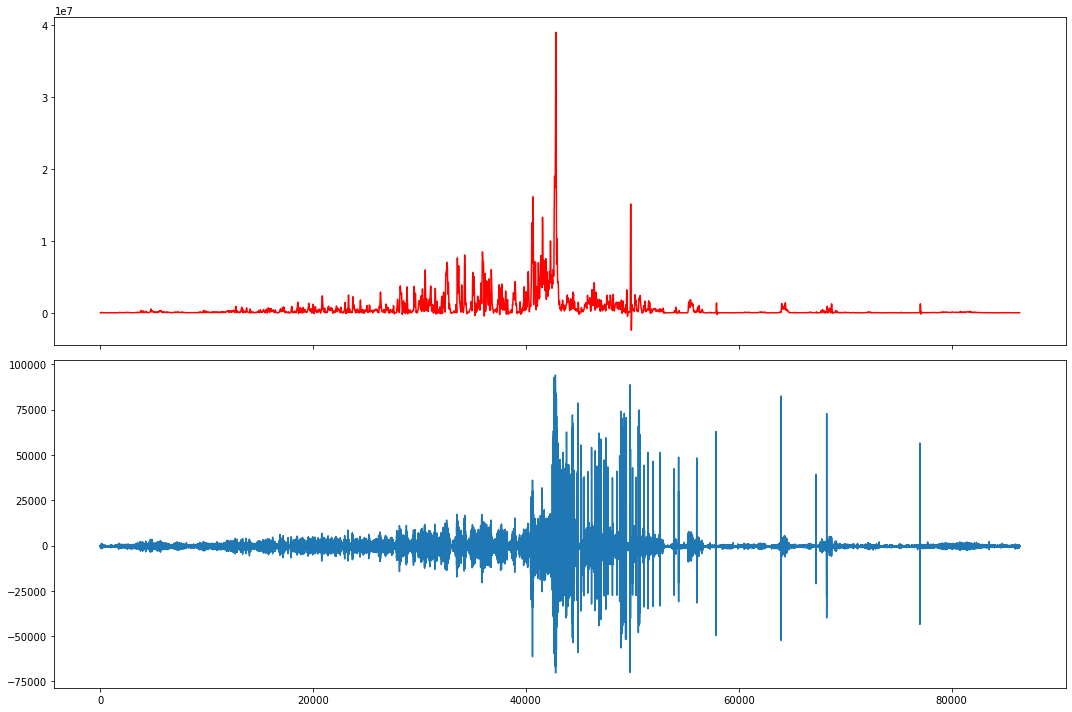

In [55]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

data = day138.copy()
data.filter(type='lowpass', freq=0.01)
# for n,d in enumerate(data):
#     data[n].data = d.data[::100]

ax[0].plot(data[0].times(), data[0].data, color='red')
ax[1].plot(day138_original[0].times(), day138_original[0].data)
# ax.set_yscale('log')
# ax[0].set_xlim(20000, 40000)
# ax[0].set_ylim(1e0, 2e8)
# ax[1].set_ylim(-5e4, 5e4)
fig.tight_layout()

In [45]:
data[0].data[::100].shape

(86399,)

In [46]:
data[0].data.shape

(8639812,)

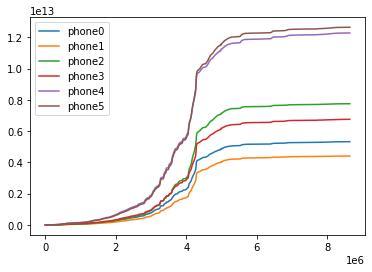

In [61]:
for n in [0, 1, 2, 3, 4, 5]:
    plt.plot(data[n].data.cumsum(), label='phone{n}'.format(n=n))
# plt.plot(data[5].data.cumsum())
plt.legend()

In [62]:
filelocs = !ls /media/sda/data/robdata/tremors/*.mseed

In [65]:
stream = obspy.read(filelocs[0])
for f in filelocs[1:]:
    stream = stream + obspy.read(f)

In [ ]:
stream.merge()

In [ ]:
stream